<a href="https://colab.research.google.com/github/slp22/data-engineering-project/blob/main/engineering_monkeypox_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Data Engineering | Pipeline

# Monkeypox Tweets

## Imports

In [1]:
import json
import logging
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, itertools
import pandas as pd
import pathlib as Path
import pickle
import PIL
import random
import seaborn as sns
import sklearn as sk
import warnings
import zipfile


import nltk
import re
import en_core_web_sm
import string
pd.set_option('display.max_colwidth', None)
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS

from sqlite3 import connect
from datetime import datetime, date
# import time
# from datetime import datetime
# from dateutil.parser import parse
# from dateutil.relativedelta import *
# from dateutil.easter import *
# from dateutil.rrule import *
# from dateutil.parser import *
# from datetime import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Google Drive

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=JiJVCmu3dhFa

# authorize access 
from google.colab import auth
auth.authenticate_user()

# read in from Google Sheets

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


Mounted at /content/drive


### Pyspark



In [3]:
# # https://towardsdatascience.com/pyspark-on-google-colab-101-d31830b238be
# # https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [5]:
!tar -xf spark-3.0.0-bin-hadoop3.2.tgz

In [6]:
!pip install -q findspark

In [7]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [8]:
import findspark
findspark.init()

In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, lower
from pyspark.sql.types import StructType,StructField, StringType, IntegerType


## 1 | Pipeline Design


* **Business Problem:** Can we build a dashboard to monitor top trending topics on Twitter about monkeypox?
* **Data source:** [Kaggle Tweets on Monkeypox ](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets)
* **Impact Hypothesis:** 

## 2 | Data Ingestion

#### 2.1  [Twitter Dataset on the 2022 MonkeyPox Outbreak](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets) 
* Dataset is list of TweetIDs

#### 2.2  [Twitter Hydrating](https://towardsdatascience.com/learn-how-to-easily-hydrate-tweets-a0f393ed340e#:~:text=Hydrating%20Tweets) with [DocNow Hydrator](https://github.com/DocNow/hydrator/releases)
* Processed on local machine
* Saved to Google Sheets

### 2.3  Import [hydrated tweets](https://drive.google.com/drive/folders/1NbddxuSF3v5YuOgjvA1G4WgfPUlKfiul?usp=sharing) from GoogleDrive to Colab

In [10]:
# import one set of tweets for EDA (section 3.1)
w = ['TweetIDs_Part1']
tweets = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())

In [11]:
# # import all tweets (section 3.2)
w = ['TweetIDs_Part1', 'TweetIDs_Part2', 'TweetIDs_Part3', 'TweetIDs_Part4', 'TweetIDs_Part5', 'TweetIDs_Part6']
df_1 = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())
df_2 = pd.DataFrame.from_records(gc.open(w[1]).sheet1.get_all_values())
df_3 = pd.DataFrame.from_records(gc.open(w[2]).sheet1.get_all_values())
df_4 = pd.DataFrame.from_records(gc.open(w[3]).sheet1.get_all_values())
df_5 = pd.DataFrame.from_records(gc.open(w[4]).sheet1.get_all_values())
df_6 = pd.DataFrame.from_records(gc.open(w[5]).sheet1.get_all_values())

## 3 | Exploratory Data Analysis

### 3.1  Explore one set: `tweets` (n = 12,656) 

In [12]:
tweets.head(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Wed May 18 21:49:25 +0000 2022,,,,1,1527043704967528453,theofficepirate,1527043356878155776,140472501,...,36791,6088,255,,Yates,Jyates5,36441,,,FALSE


In [13]:
tweets.columns = tweets.iloc[0]
tweets = tweets.drop(index=tweets.index[0])

In [14]:
tweets.head(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Wed May 18 21:49:25 +0000 2022,,,,1,1527043704967528453,theofficepirate,1527043356878155776,140472501,...,36791,6088,255,,Yates,Jyates5,36441,,,FALSE
2,,Fri May 20 20:43:44 +0000 2022,,,,0,1527751952448344065,,,,...,134,553,3,"Chicago, IL",Patrick,LeftistHank,10782,,,FALSE


In [15]:
cols_list = list(tweets.columns)
cols_list

['coordinates',
 'created_at',
 'hashtags',
 'media',
 'urls',
 'favorite_count',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_id',
 'retweet_count',
 'retweet_id',
 'retweet_screen_name',
 'source',
 'text',
 'tweet_url',
 'user_created_at',
 'user_id',
 'user_default_profile_image',
 'user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_location',
 'user_name',
 'user_screen_name',
 'user_statuses_count',
 'user_time_zone',
 'user_urls',
 'user_verified']

In [16]:
tweets['hashtags']
print('num unique hashtags', tweets['hashtags'].nunique())

num unique hashtags 528


In [17]:
tweets['possibly_sensitive'][0:2]

1    
2    
Name: possibly_sensitive, dtype: object

In [18]:
tweets['text']

1                                                                                                                                                                                                                    @theofficepirate You bro remember them talking about monkey pox lol
2                                                                                                                                                                                                                                          oh monkey POX? I thought you said monkey POGS
3                                                                                                                                                                                                                          If I get monkey pox y’all gotta bring me the juiciest bananas
4        Great, the initial Monkey pox symptoms read like how I generally feel. People in both England and Scotland have been quarantined.\n\nInitial symptom

In [19]:
tweets['tweet_url'][0:2]

1        https://twitter.com/Jyates5/status/1527043704967528453
2    https://twitter.com/LeftistHank/status/1527751952448344065
Name: tweet_url, dtype: object

In [20]:
tweets['lang'].unique()
print('num unique languages', tweets['lang'].nunique())

num unique languages 40


In [21]:
tweets['user_created_at']

1        Fri Apr 01 00:29:41 +0000 2011
2        Fri Apr 01 13:14:03 +0000 2022
3        Fri Apr 01 15:12:02 +0000 2011
4        Fri Apr 01 16:27:26 +0000 2011
5        Fri Apr 01 17:41:17 +0000 2016
                      ...              
12652    Wed Sep 30 18:20:38 +0000 2015
12653    Wed Sep 30 19:12:03 +0000 2020
12654    Wed Sep 30 22:42:35 +0000 2020
12655    Wed Sep 30 23:06:12 +0000 2009
12656    Wed Sep 30 23:38:29 +0000 2009
Name: user_created_at, Length: 12656, dtype: object

In [22]:
tweets['user_id']
print('num unique user id', tweets['user_id'].nunique())

num unique user id 11033


In [23]:
tweets['user_location']
print('num unique location', tweets['user_location'].nunique())

num unique location 4508


In [24]:
tweets['user_screen_name']
print('num unique screen names', tweets['user_screen_name'].nunique())

num unique screen names 11033


In [25]:
tweets = tweets[['user_created_at',
                 'user_screen_name',
                 'text',
                 'tweet_url',
                 'user_location',
                 'hashtags']]
tweets.head(2)

,user_created_at,user_screen_name,text,tweet_url,user_location,hashtags
1,Fri Apr 01 00:29:41 +0000 2011,Jyates5,@theofficepirate You bro remember them talking about monkey pox lol,https://twitter.com/Jyates5/status/1527043704967528453,,
2,Fri Apr 01 13:14:03 +0000 2022,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,"Chicago, IL",


In [26]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12656 entries, 1 to 12656
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_created_at   12656 non-null  object
 1   user_screen_name  12656 non-null  object
 2   text              12656 non-null  object
 3   tweet_url         12656 non-null  object
 4   user_location     12656 non-null  object
 5   hashtags          12656 non-null  object
dtypes: object(6)
memory usage: 692.1+ KB


In [27]:
tweets.reset_index(drop=True)

,user_created_at,user_screen_name,text,tweet_url,user_location,hashtags
0,Fri Apr 01 00:29:41 +0000 2011,Jyates5,@theofficepirate You bro remember them talking about monkey pox lol,https://twitter.com/Jyates5/status/1527043704967528453,,
1,Fri Apr 01 13:14:03 +0000 2022,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,"Chicago, IL",
2,Fri Apr 01 15:12:02 +0000 2011,MyNameIsRickyM,If I get monkey pox y’all gotta bring me the juiciest bananas,https://twitter.com/MyNameIsRickyM/status/1528100542345527296,Ohio,
3,Fri Apr 01 16:27:26 +0000 2011,Just_sue_now,"Great, the initial Monkey pox symptoms read like how I generally feel. People in both England and Scotland have been quarantined.\n\nInitial symptoms of monkeypox include fever, headache, muscle aches, backache, swollen lymph nodes, chills and exhaustion, the UKHSA said.",https://twitter.com/Just_sue_now/status/1525370151025115137,"Cumbernauld, Glasgow",
4,Fri Apr 01 17:41:17 +0000 2016,JackPaceSr,"@freidergeist @Cameo3D @pullenmyleg_ @Breaking911 If an mRNA vaxx is announced for monkey pox, regardless of its pandemic level, I will say cameo 3D is right. \nIf this is referenced in any way to push a small pox vax, cameo is still right",https://twitter.com/JackPaceSr/status/1527035801871294464,"Here, before you",
...,...,...,...,...,...,...
12651,Wed Sep 30 18:20:38 +0000 2015,theoceanlawyers,"@thecoastguy @TimNielsenDay Patent applied for on June 22, 2021. [See Docket No. FDA-2020-E-1328]",https://twitter.com/theoceanlawyers/status/1527328539648745473,"Palm Beach, FL",
12652,Wed Sep 30 19:12:03 +0000 2020,RolexCola,Ian Brown looks like he has monkey pox,https://twitter.com/RolexCola/status/1527779614554218496,"Gay Street, Baltimore",
12653,Wed Sep 30 22:42:35 +0000 2020,DeeKno_,@SkyNews how tf are people contracting “monkey pox” in the UK 😭?,https://twitter.com/DeeKno_/status/1525802680890888193,,
12654,Wed Sep 30 23:06:12 +0000 2009,ChipFranks,@ConceptualJames We really need a legitimate law enforcement agency to go after these fellows.\n\nEvent 201 COULD have been luck. An accurate prediction of monkey pox means they’re causing it somehow.\n\nWe need to get them!,https://twitter.com/ChipFranks/status/1527767273225609217,God’s Country (Texas),


In [28]:
tweets.to_csv('/content/tweets_eda.csv')

### 3.2  Clean rest of tweet data: `df` (n = 127,940)

In [29]:
# continuing from section 2.3
# use first row as col name, and drop first row before concatenating 
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]

for d in dfs: 
  d.columns = d.iloc[0]
  d = d.drop(index=d.index[0],
               axis=0,
               inplace=True)

In [30]:
df_2.head(3)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Thu May 26 20:31:06 +0000 2022,,,,0,1529923099424178191,dustinbennett76,1529921422134497287,43171823,...,182,501,3,,Work in Progress,Kenny_Swift,8117,,,FALSE
2,,Sun May 22 22:20:07 +0000 2022,,,,0,1528500983893983233,OnlineAlison,1528484226969923586,24115438,...,1,36,0,,Saniye,biirSaniye,238,,,FALSE
3,,Thu May 26 22:54:22 +0000 2022,,,,1,1529959154059730946,,,,...,2297,1311,8,"Johannesburg, South Africa",Lebogang,lebza_mtwana,70755,,,FALSE


In [31]:
# concatenate dfs
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
df.tail()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
127936,,Sat Jul 23 00:00:17 +0000 2022,,,https://www.cdc.gov/poxvirus/monkeypox/transmission.html https://twitter.com/NBCNews/status/1550620740235530240,1,1550631852393828352,,,,...,529,972,21,,Wendy,wmzraz,41861,,,FALSE
127937,,Sat Jul 23 00:00:00 +0000 2022,,,https://endpts.com/bavarian-nordics-monkeypox-vaccine-wins-positive-opinion-from-ema-committee/,4,1550631781396729856,,,,...,24498,40,530,Global,Endpoints News,endpts,44967,,http://endpts.com,FALSE
127938,,Sat Jul 23 00:00:18 +0000 2022,Monkeypox HealthierJC,https://twitter.com/HealthierJC/status/1550631856336506886/photo/1,,0,1550631856336506886,,,,...,2330,1582,32,"Jersey City, NJ",Healthier JC,HealthierJC,8091,,http://healthierjc.com,FALSE
127939,,Sat Jul 23 00:00:23 +0000 2022,,,https://twitter.com/i/broadcasts/1OdKrBzXyMQKX,0,1550631877781835776,,,,...,1818,942,34,Los Angeles,(((Luke Ford))),lukeford,61434,,http://www.lukeford.net,FALSE
127940,,Sat Jul 23 00:00:07 +0000 2022,,,http://crweworld.com/article/world/2448896/2-children-diagnosed-with-monkeypox-in-us,0,1550631810970750976,,,,...,1051,2047,42,"Las Vegas, NV",Crwe World,CrweWorld,1482340,,http://crweworld.com,FALSE


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229181 entries, 1 to 127940
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   coordinates                 229181 non-null  object
 1   created_at                  229181 non-null  object
 2   hashtags                    229181 non-null  object
 3   media                       229181 non-null  object
 4   urls                        229181 non-null  object
 5   favorite_count              229181 non-null  object
 6   id                          229181 non-null  object
 7   in_reply_to_screen_name     229181 non-null  object
 8   in_reply_to_status_id       229181 non-null  object
 9   in_reply_to_user_id         229181 non-null  object
 10  lang                        229181 non-null  object
 11  place                       229181 non-null  object
 12  possibly_sensitive          229181 non-null  object
 13  quote_id                    2

In [33]:
# Int64Index: 229181 entries, 1 to 127940, remove duplicates

duplicateRows = df[df.duplicated()]
duplicateRows

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
352,,Sat May 14 10:31:43 +0000 2022,,,,742,1525423607450566657,,,,...,1529,1661,2,"Preston, England",irrelevant Honky.🏴󠁧󠁢󠁥󠁮󠁧󠁿 (john).,british_ska,14836,,,FALSE
828,,Thu May 19 18:33:40 +0000 2022,,,https://www.theatlantic.com/health/archive/2022/05/monkeypox-outbreak-covid-pandemic/629920/,5609,1527356834260013058,,,,...,399856,1964,8128,At home,Ed Yong,edyong209,120276,,http://www.theatlantic.com/author/ed-yong/,TRUE
887,,Wed May 18 20:58:11 +0000 2022,monkeypox,,,6403,1527030815506432006,,,,...,1003091,1034,5165,🌍,Disclose.tv,disclosetv,1008,,https://www.disclose.tv,FALSE
889,,Sat May 14 09:22:09 +0000 2022,,,,3847,1525406097766588420,,,,...,1003091,1034,5165,🌍,Disclose.tv,disclosetv,1008,,https://www.disclose.tv,FALSE
1390,,Mon May 16 17:37:58 +0000 2022,,,,72,1526255652066172930,UKHSA,1526255382573760515,41822696,...,524731,711,3179,United Kingdom,UK Health Security Agency,UKHSA,24830,,https://www.gov.uk/government/organisations/uk-health-security-agency,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127905,,Sat Jul 23 00:00:54 +0000 2022,,,,0,1550632007763480578,Billyhottakes,1550594997887574019,1245183898826543000,...,46,336,0,,Phil,ProcessCmplt76,4084,,,FALSE
127922,,Sat Jul 23 00:05:39 +0000 2022,monkeypox MPX,https://twitter.com/HelenBranswell/status/1550633203077103616/photo/1,,597,1550633203077103616,,,,...,231128,2094,6990,"Boston, MA",Helen Branswell 🇺🇦,HelenBranswell,48482,,http://www.statnews.com,TRUE
127928,,Sat Jul 23 00:06:04 +0000 2022,,,,6,1550633306932346882,VICE,1550631856567197696,23818581,...,406,1120,0,,T.W. Driedger 🏴,AnarchoMenno,3656,,https://livingstateless.substack.com/,FALSE
127931,,Sat Jul 23 00:00:25 +0000 2022,,,,0,1550631884245217280,LandauDave,1550600625091756032,921614845,...,5,11,0,,John W,Johnwill605,911,,,FALSE


In [34]:
df.drop_duplicates(subset=None, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215365 entries, 1 to 127940
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   coordinates                 215365 non-null  object
 1   created_at                  215365 non-null  object
 2   hashtags                    215365 non-null  object
 3   media                       215365 non-null  object
 4   urls                        215365 non-null  object
 5   favorite_count              215365 non-null  object
 6   id                          215365 non-null  object
 7   in_reply_to_screen_name     215365 non-null  object
 8   in_reply_to_status_id       215365 non-null  object
 9   in_reply_to_user_id         215365 non-null  object
 10  lang                        215365 non-null  object
 11  place                       215365 non-null  object
 12  possibly_sensitive          215365 non-null  object
 13  quote_id                    2

In [36]:
# filter for tweets in English
print('English entries:', (df[df["lang"] == 'en'].count())['lang'])

English entries: 197594


In [37]:
df = df[(df['lang'] == 'en')]
df['lang'].unique()

array(['en'], dtype=object)

In [38]:
# convert timestamp to date
df['date'] = pd.to_datetime(df['user_created_at'],
                            format='%a %b %d %H:%M:%S +0000 %Y', 
                            errors='coerce').dt.date
df[['date']][:2]

,date
1,2011-04-01
2,2022-04-01


In [39]:
# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197594 entries, 1 to 127940
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   coordinates                 197594 non-null  object        
 1   created_at                  197594 non-null  object        
 2   hashtags                    197594 non-null  object        
 3   media                       197594 non-null  object        
 4   urls                        197594 non-null  object        
 5   favorite_count              197594 non-null  object        
 6   id                          197594 non-null  object        
 7   in_reply_to_screen_name     197594 non-null  object        
 8   in_reply_to_status_id       197594 non-null  object        
 9   in_reply_to_user_id         197594 non-null  object        
 10  lang                        197594 non-null  object        
 11  place                       197594 non-

In [40]:
# filter for tweets in 2022
df = df.loc[(df['date'] >= '2022-01-01')]
df.head(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,date
2,,Fri May 20 20:43:44 +0000 2022,,,,0,1527751952448344065,,,,...,553,3,"Chicago, IL",Patrick,LeftistHank,10782,,,FALSE,2022-04-01
6,,Thu May 19 21:10:22 +0000 2022,,,,2,1527396267633963019,,,,...,465,0,,CACTI,YUCCAYAWN,4113,,,FALSE,2022-04-01


In [41]:
# explore location column
print(df['user_location'].value_counts())
print('\n', 'Num unique:', df['user_location'].nunique())

                          15258
Sullivans Island           1981
United States               467
Binance Smart Chain         225
USA                         187
                          ...  
OR                            1
Final Firing Position         1
Hay Bay, Ontario              1
Some Place Wild & Free        1
North of the Wall             1
Name: user_location, Length: 3818, dtype: int64

 Num unique: 3818


In [42]:
# explore handles
print(df['user_screen_name'].value_counts())
print('\n', 'Num unique:', df['user_screen_name'].nunique())

EMorgan52          1981
RolandBakerIII      265
MonkeyPoxBSC        225
tickrob76           161
bulletin_ex         153
                   ... 
Thekingjames68        1
UCRSAE                1
NicolaiSavaskan       1
bengalsfanman11       1
LongCOVIDNatl         1
Name: user_screen_name, Length: 15990, dtype: int64

 Num unique: 15990


In [43]:
# remove numbers, punctuation, and capital letters from location column
alphanumeric = lambda x: re.sub('\w*\d\w*',' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
                          
df['user_location'] = df.user_location.map(alphanumeric).map(punc_lower)
df.tail(20)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,date
127668,,Sat Jul 23 00:13:00 +0000 2022,,,,0,1550635051980914689,,,,...,5,0,new jersey,U.S.A news,MfkrAlqrn,2856,,,FALSE,2022-04-02
127690,,Sat Jul 23 00:13:10 +0000 2022,,,,1,1550635094867681280,MorningAnswer,1550631684193894402,58217912,...,430,0,illinois usa,OldArmyNurse4 🗽,OldArmyNurse4,23609,,,FALSE,2022-04-26
127711,,Sat Jul 23 00:16:24 +0000 2022,,,https://exbulletin.com/world/international/1760717/,0,1550635906607882240,,,,...,1,1,,ExBulletin,bulletin_ex,158566,,https://exbulletin.com/,FALSE,2022-01-14
127744,,Sat Jul 23 00:13:22 +0000 2022,,,https://www.aol.com/news/monkeypox-virus-could-become-entrenched-041041732-145107239.html?soc_src=social-sh&soc_trk=tw&tsrc=twtr,0,1550635144997912577,,,,...,30,0,,clare belote,BeloteClare,528,,,FALSE,2022-03-03
127745,,Sat Jul 23 00:12:10 +0000 2022,,https://twitter.com/Momof4Cats4/status/1550634841951113223/photo/1,https://globalnewsink.com/u-s-confirms-first-two-cases-of-monkeypox-in-children-one-case-is-in-california/,1,1550634841951113223,,,,...,15724,4,queens ny,Momof4Cats🐈🐱,Momof4Cats4,10900,,,FALSE,2022-04-14
127749,,Sat Jul 23 00:06:11 +0000 2022,,,http://Globalnews.ca https://www.onzededepart.com/cbmimgh0dhbzoi8vz2xvymfsbmv3cy5jys9uzxdzlzkwmtaxotivbw9ua2v5cg94lxvzl9ibaaoc5/,0,1550633337013805056,,,,...,1,1,,a.belka70,ABelka70,23460,,,FALSE,2022-04-03
127775,,Sat Jul 23 00:06:57 +0000 2022,,,,1,1550633529914040320,benryanwriter,1549596357983363072,1666939494,...,1181,0,montréal québec,whatnot,whatnotwantsnot,2322,,,FALSE,2022-05-04
127812,,Sat Jul 23 00:11:36 +0000 2022,,,https://netionaldastak.com/monkeypox-us-confirms-first-two-cases-in-children/,0,1550634701626425345,,,,...,1489,0,,Netional Dastak,NetionalD,67625,,https://www.netionaldastak.com,FALSE,2022-01-04
127815,,Sat Jul 23 00:11:43 +0000 2022,,,,1,1550634728256053248,suricidal,1550634528556851202,1433136669117517800,...,171,1,,Professor niggaraneus,freejohnfr,2129,,,FALSE,2022-07-17
127819,,Sat Jul 23 00:11:33 +0000 2022,,,https://www.sciencedirect.com/science/article/pii/S1995820X22000414,0,1550634686568955905,,,,...,30,0,polk city fl,XDeddudeX,DeddudeX,29,,,FALSE,2022-04-27


In [44]:
# remove emojis from location column
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
df['user_location'].head(5)

2              chicago  il
6                         
7    charlie lastra s arms
8    charlie lastra s arms
9                         
Name: user_location, dtype: object

### 3.3  Corpus: English `tweets` (n = 28,281)

In [45]:
df = df[['date',
         'user_screen_name',
         'text',
         'tweet_url',
         'user_location',
         'hashtags']]
df.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
2,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,chicago il,
6,2022-04-01,YUCCAYAWN,lemme be clear ... if you like your monkey pox im afraid of where my life is going,https://twitter.com/YUCCAYAWN/status/1527396267633963019,,


In [46]:
df.reset_index(drop=True)

,date,user_screen_name,text,tweet_url,user_location,hashtags
0,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,chicago il,
1,2022-04-01,YUCCAYAWN,lemme be clear ... if you like your monkey pox im afraid of where my life is going,https://twitter.com/YUCCAYAWN/status/1527396267633963019,,
2,2022-04-01,pufpuffprincess,"@KIINGEFFIE_ @JayceBliss @Carol1mcs @TMZ Yes, Monkey pox can affect people of every race.",https://twitter.com/pufpuffprincess/status/1527398696907857921,charlie lastra s arms,
3,2022-04-01,pufpuffprincess,@Craig4lyfe23 @NateSanti @Youngkid_Vibes @TMZ Monkey pox does not come from monkeys. \nThe people who have been affected in the recent outbreak aren't Africans and the recorded outbreaks didn't take place in Africa.\nRacism comes in all forms and calling it out no matter how small it seems doesn't minimalize racism as a whole,https://twitter.com/pufpuffprincess/status/1527395142377869317,charlie lastra s arms,
4,2022-04-01,Xenon1337xV2,Not happening. \n\nThe vast majority will believe the small pox/monkey pox MSN bullshit just as they have fell for the covid and Ukraine bollox https://t.co/caYUrKVpW3,https://twitter.com/Xenon1337xV2/status/1528099437473677312,,
...,...,...,...,...,...,...
28493,2022-04-07,VassilionLinda,@SebGorka I'd rather get monkey pox.,https://twitter.com/VassilionLinda/status/1550633092921958400,las vegas nv,
28494,2022-04-21,pike_pole_pete,@denise_dewald Is someone dx with MRSA more susceptible to monkeypox? Thanks,https://twitter.com/pike_pole_pete/status/1550632375352164353,ottawa ontario,
28495,2022-04-08,FoolHomeschool,"@michaelbd HOW did he only end up with Monkey Pox? Holy crap thats a lot of damn sex. And pee. My goodness. Maybe get checked for strep, too? I dunno?",https://twitter.com/FoolHomeschool/status/1550632843927326720,md meowtains of wv,
28496,2022-02-08,LongCOVIDNatl,"Thanks to our Long COVID Justice Advisory Team member @CeciliaGentili, @actupny and all those involved in this powerful, urgent call for action on #monkeypox https://t.co/hnV3k9gnun",https://twitter.com/LongCOVIDNatl/status/1550632229868650496,,monkeypox


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28498 entries, 2 to 127921
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28498 non-null  object
 1   user_screen_name  28498 non-null  object
 2   text              28498 non-null  object
 3   tweet_url         28498 non-null  object
 4   user_location     28498 non-null  object
 5   hashtags          28498 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [48]:
# Save corpus
df.to_pickle('/content/drive/MyDrive/tweets.pkl')
df.to_csv(r'/content/drive/MyDrive/tweets.csv', index=False)
df.to_csv(r'/content/tweets.csv', index=False)

# 4 | Storage

### 4.1  Create SQL database: `monkeypox.db`

In [49]:
# https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    # find columns in the dataframe
    cols = input_df.columns
    # print(cols) 
    cols_string = ','.join(cols)
    # print(cols_string) 
    val_wildcard_string = ','.join(['?'] * len(cols))

    # connect to a db file if it exists, else create a new file
    try:
        con = sqlite3.connect(db_name)
    except sqlite3.Error:
        print("Error open db.\n")
        return False
    cur = con.cursor()

    # con = sqlite3.connect(db_name)
    # cur = con.cursor()

    # create table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    print(sql_string)    
    cur.execute(sql_string)

    # upload df
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
  
    # commit changes and close connection
    con.commit()
    con.close()

In [50]:
#  https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def sql_query_to_pd(sql_query_string: str, db_name: str ='mpox.db') -> pd.DataFrame:
    
    # connect to sql db
    con = sqlite3.connect(db_name)

    # execute sql query
    cursor = con.execute(sql_query_string)

    # fetch data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # close the connection
    con.close()

    # return as df
    return pd.DataFrame(result_data, columns=cols)

### 4.2  Save tweets to database: `corpus`

In [51]:
# read csv as df
input_df = pd.read_csv('/content/tweets.csv')

# upload df as a SQL table
pd_to_sqlDB(input_df,
            table_name='corpus',
            db_name='mpox.db')

CREATE TABLE corpus (date,user_screen_name,text,tweet_url,user_location,hashtags);


### 4.3  Count locations: `location`

In [52]:
sql_query_string = """
  SELECT user_location, COUNT(user_location) AS count
  FROM corpus
  GROUP BY user_location
  ORDER BY
    COUNT(user_location) DESC
"""

In [53]:
location_df = sql_query_to_pd(sql_query_string, db_name='mpox.db')

In [54]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  3588 non-null   object
 1   count          3589 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.2+ KB


In [55]:
location_df.tail(10)

,user_location,count
3579,za,1
3580,zanzibarland,1
3581,zeta zero nation,1
3582,zimbaba south africa,1
3583,zimbabwe,1
3584,zimbabwe south africa america,1
3585,zora n he they xe lesbian,1
3586,zwitserland baden,1
3587,zythos,1
3588,None,0


### 4.4  Read tables from database: `corpus_df` and `location_df`

In [56]:
sql_query_string = """
    SELECT *
    FROM corpus
"""
corpus_df = sql_query_to_pd(sql_query_string, db_name='mpox.db')
corpus_df

,date,user_screen_name,text,tweet_url,user_location,hashtags
0,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751952448344065,chicago il,None
1,2022-04-01,YUCCAYAWN,lemme be clear ... if you like your monkey pox im afraid of where my life is going,https://twitter.com/YUCCAYAWN/status/1527396267633963019,None,None
2,2022-04-01,pufpuffprincess,"@KIINGEFFIE_ @JayceBliss @Carol1mcs @TMZ Yes, Monkey pox can affect people of every race.",https://twitter.com/pufpuffprincess/status/1527398696907857921,charlie lastra s arms,None
3,2022-04-01,pufpuffprincess,@Craig4lyfe23 @NateSanti @Youngkid_Vibes @TMZ Monkey pox does not come from monkeys. \nThe people who have been affected in the recent outbreak aren't Africans and the recorded outbreaks didn't take place in Africa.\nRacism comes in all forms and calling it out no matter how small it seems doesn't minimalize racism as a whole,https://twitter.com/pufpuffprincess/status/1527395142377869317,charlie lastra s arms,None
4,2022-04-01,Xenon1337xV2,Not happening. \n\nThe vast majority will believe the small pox/monkey pox MSN bullshit just as they have fell for the covid and Ukraine bollox https://t.co/caYUrKVpW3,https://twitter.com/Xenon1337xV2/status/1528099437473677312,None,None
...,...,...,...,...,...,...
28493,2022-04-07,VassilionLinda,@SebGorka I'd rather get monkey pox.,https://twitter.com/VassilionLinda/status/1550633092921958400,las vegas nv,None
28494,2022-04-21,pike_pole_pete,@denise_dewald Is someone dx with MRSA more susceptible to monkeypox? Thanks,https://twitter.com/pike_pole_pete/status/1550632375352164353,ottawa ontario,None
28495,2022-04-08,FoolHomeschool,"@michaelbd HOW did he only end up with Monkey Pox? Holy crap thats a lot of damn sex. And pee. My goodness. Maybe get checked for strep, too? I dunno?",https://twitter.com/FoolHomeschool/status/1550632843927326720,md meowtains of wv,None
28496,2022-02-08,LongCOVIDNatl,"Thanks to our Long COVID Justice Advisory Team member @CeciliaGentili, @actupny and all those involved in this powerful, urgent call for action on #monkeypox https://t.co/hnV3k9gnun",https://twitter.com/LongCOVIDNatl/status/1550632229868650496,None,monkeypox


In [57]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28498 entries, 0 to 28497
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28498 non-null  object
 1   user_screen_name  28498 non-null  object
 2   text              28498 non-null  object
 3   tweet_url         28498 non-null  object
 4   user_location     13171 non-null  object
 5   hashtags          2827 non-null   object
dtypes: object(6)
memory usage: 1.3+ MB


In [58]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  3588 non-null   object
 1   count          3589 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.2+ KB


# 5 | Processing

#### 5.1  Word Count (PySpark)
* groupby, count, agg, 
* google = pyspark word frequency


In [59]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [60]:
spark_df = spark.createDataFrame(corpus_df)
spark_df.printSchema()


root
 |-- date: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_url: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- hashtags: string (nullable = true)



In [61]:
df_schema = StructType([StructField("date", IntegerType(), True)])

In [62]:
spark_df = spark_df.withColumn('text', 
                               explode(split(lower(col('text')), '\s')))

In [63]:
(spark_df.groupBy('text')
  .count()
  .orderBy('count', ascending=False)
  .show(50))

+----------+-----+
|      text|count|
+----------+-----+
|       the|20759|
|          |17730|
|    monkey|15696|
|        to|12088|
|       pox|11945|
|         a|10117|
|       and| 9364|
|        is| 8922|
|        of| 8873|
|        in| 7440|
| monkeypox| 6819|
|         i| 5311|
|       for| 5275|
|       you| 5166|
|      that| 4382|
|        it| 4291|
|       are| 3873|
|      with| 3594|
|      have| 3512|
|      they| 3437|
|      this| 3337|
|        on| 3332|
|        be| 3236|
|       not| 3167|
|        we| 2690|
|       who| 2593|
|      will| 2311|
|      from| 2244|
|       get| 2232|
|        as| 2165|
|        so| 2070|
|       all| 2048|
|     about| 2006|
|      just| 1966|
|      your| 1899|
|        if| 1886|
|     covid| 1871|
|       has| 1806|
|        or| 1806|
|       was| 1794|
|       now| 1789|
|#monkeypox| 1772|
|      like| 1750|
|      what| 1737|
|    people| 1717|
|        by| 1638|
|        at| 1632|
|       but| 1617|
|    health| 1597|
|        no|

In [64]:
spark_df.groupBy('text')

In [65]:
spark_df = spark_df.withColumn('user_location', 
                               explode(split(lower(col('user_location')), '\s')))

In [66]:
(spark_df.groupBy('user_location')
  .count()
  .orderBy('count', ascending=False)
  .show(150))

+------------------+------+
|     user_location| count|
+------------------+------+
|                  |156784|
|            island| 51580|
|         sullivans| 50587|
|               usa| 26865|
|            united| 12154|
|            states|  9338|
|               the|  9156|
|            canada|  8768|
|               new|  8521|
|             earth|  7142|
|                ny|  6902|
|                of|  6079|
|           england|  5696|
|                ca|  5582|
|           ontario|  5474|
|           florida|  5419|
|             texas|  5310|
|             south|  5025|
|              york|  4730|
|                tx|  4345|
|      pennsylvania|  3969|
|                in|  3941|
|                 i|  3788|
|                fl|  3631|
|            ottawa|  2961|
|           kingdom|  2885|
|             india|  2795|
|        california|  2777|
|                nc|  2719|
|            london|  2707|
|                 s|  2683|
|            nevada|  2641|
|              your|

In [67]:
# https://simplemaps.com/data/world-cities

### 5.2 Topic Modeling

In [68]:
terms = corpus_df['text']
terms.shape

(28498,)

In [69]:
# custom stop words 
stopwords = nltk.corpus.stopwords.words('english')

custom_words = ['monkey',
             'pox',
             'monkeypox',
             'people',
             'covid',
             'amp',
             '19',
             '2022',
             'another',
             'co', 'https', 'cases', 'case', 'new', 'first', 'via', 'confirmed', 'us',
             'going', 'one', 'know',
             'get', 'like', 'go', 'got', 'time', 'think', 'want',
             'health', 'declares', 'outbreak', 'world', 'public', 'declared', 'news', 'says',
            'total', 'take', 'virus', 'already', 'getting', 'sure',
            'spread', 'disease', 'next', 'would', 'need']
stopwords.extend(custom_words)


In [70]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords, 
                                min_df=0.01, 
                                max_df=.95)
tf_vectorizer

TfidfVectorizer(max_df=0.95, min_df=0.01,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [71]:
# document-term matrix with TF-IDF
tf_doc_term_mtx = tf_vectorizer.fit_transform(terms)
type(tf_doc_term_mtx)

scipy.sparse.csr.csr_matrix

In [72]:
tf_doc_term_df = pd.DataFrame(tf_doc_term_mtx.toarray(), 
                              columns=tf_vectorizer.get_feature_names_out())
tf_doc_term_df.head(2)

,aids,also,anyone,around,back,biden,cdc,children,cnn,come,...,trump,trying,two,vaccine,vaccines,vax,way,well,years,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# # double check that domain specfic words were omitted 
print('monkey' in tf_vectorizer.get_feature_names_out())
print('pox' in tf_vectorizer.get_feature_names_out())
print('monkeypox' in tf_vectorizer.get_feature_names_out())
print('covid' in tf_vectorizer.get_feature_names_out())

# who and what are mentioned in the corpus? not cdc, trump mentioned 
print('rash' in tf_vectorizer.get_feature_names_out())
print('fever' in tf_vectorizer.get_feature_names_out())
print('cdc:', 'cdc' in tf_vectorizer.get_feature_names_out())
print('cdcgov' in tf_vectorizer.get_feature_names_out())
print('centers for disease control and prevention' in tf_vectorizer.get_feature_names_out())
print('walensky' in tf_vectorizer.get_feature_names_out())
print('biden:', 'biden' in tf_vectorizer.get_feature_names_out())



False
False
False
False
False
False
cdc: True
False
False
False
biden: True


In [74]:
# V     visible variables     doc_term             input (corpus matrix)
# W     weights               doc_topic            feature set
# H     hidden variables      topic_term           coefficients

In [75]:
V = tf_doc_term_mtx
V.shape

(28498, 82)

In [76]:
# W matrix = feature set & weights
nmf = NMF(n_components=5, init=None)
W = nmf.fit_transform(V).round(3)
print(type(W))
W.shape

<class 'numpy.ndarray'>


(28498, 5)

In [77]:
# H matrix = hidden variables & coefficients 
H = pd.DataFrame(nmf.components_.round(2),
                 index = ['c1', 
                          'c2',
                          'c3',
                          'c4', 
                          'c5'],
                 columns = tf_vectorizer.get_feature_names_out())
print('H.shape:',  H.shape)
H.T.style.background_gradient(cmap='Blues')


H.shape: (5, 82)


,c1,c2,c3,c4,c5
aids,0.000000,0.000000,0.380000,0.000000,0.180000
also,0.000000,0.030000,0.070000,0.000000,0.370000
anyone,0.000000,0.020000,0.090000,0.020000,0.280000
around,0.000000,0.020000,0.030000,0.000000,0.340000
back,0.000000,0.000000,0.000000,0.000000,0.480000
biden,0.090000,0.030000,0.000000,0.520000,0.410000
cdc,0.100000,0.120000,0.310000,0.010000,0.290000
children,0.010000,0.000000,0.180000,0.000000,0.220000
cnn,0.000000,0.000000,0.000000,4.410000,0.000000
come,0.000000,0.010000,0.000000,0.000000,0.310000


In [78]:
# function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [79]:
topics = display_topics(nmf, tf_vectorizer.get_feature_names_out(), 20)


Topic  0
emergency, global, spreading, cdc, biden, pandemic, said, risk, day, yet, even, may, government, could, coming, children, fear, foxnews, states, stop

Topic  1
vaccine, smallpox, cdc, vaccines, shingles, yet, day, states, risk, everyone, vax, foxnews, make, biden, also, many, even, government, really, since

Topic  2
gay, men, sex, community, spreading, aids, cdc, stop, contact, man, children, month, risk, say, way, said, anyone, everyone, since, many

Topic  3
cnn, biden, trump, real, democrats, states, make, msnbc, years, good, man, please, said, since, day, never, let, right, say, even

Topic  4
dont, pandemic, see, moneypox, well, im, still, right, say, vaccines, even, thing, back, way, good, really, stop, biden, make, could


### 5.3  Word Cloud

In [80]:
# use doc_term for word cloud
words = tf_doc_term_df
words.head(2)

,aids,also,anyone,around,back,biden,cdc,children,cnn,come,...,trump,trying,two,vaccine,vaccines,vax,way,well,years,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


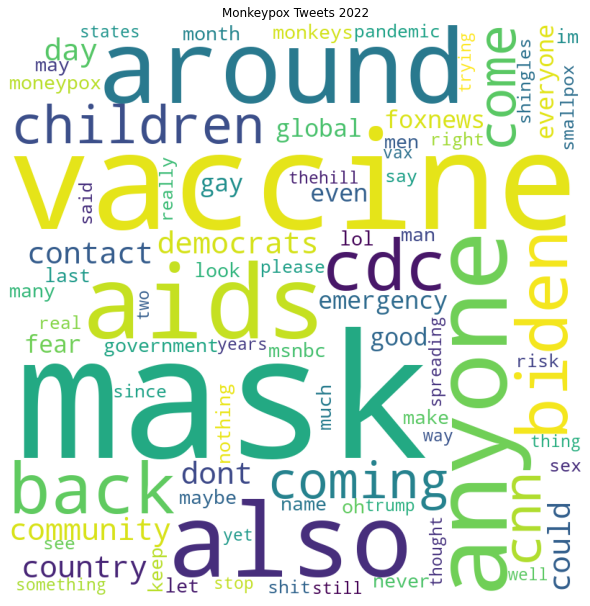

In [81]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

comment_words = ''
stopwords = set(stopwords)
 
for val in words:
    val = str(val)
    tokens = val.split()     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot WordCloud                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Monkeypox Tweets 2022')
plt.savefig("monkeypox-tweets-word-cloud.jpeg");

In [82]:
comment_words
type(comment_words)

words = np.array(comment_words)
words = pd.Series(words)
type(words)


pandas.core.series.Series

In [83]:
# word cloud list of words
words.to_csv('/content/words_for_cloud.csv')


In [84]:
print(words)

0    aids also anyone around back biden cdc children cnn come coming community contact could country day democrats dont emergency even everyone fear foxnews gay global good government im keep last let lol look make man many mask masks may maybe men moneypox monkeys month msnbc much name never nothing oh pandemic please real really right risk said say see sex shingles shit since smallpox something spreading states still stop thehill thing thought trump trying two vaccine vaccines vax way well years yet 
dtype: object


### 5.4  Case Counts by State

In [85]:
# import state coordinates from https://developers.google.com/public-data/docs/canonical/states_csv 
# import  US case count by state from https://www.cdc.gov/poxvirus/monkeypox/response/2022/us-map.html

w = ['USA-State-Coordinates', '2022-US-mpx-cases-by-state']

state_coor = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())
mpx_cases = pd.DataFrame.from_records(gc.open(w[1]).sheet1.get_all_values())

In [86]:
state_coor.head(2)

,0,1,2,3
0,state,latitude,longitude,name
1,AL,32.318231,-86.902298,Alabama


In [87]:
mpx_cases.head(2)

,0,1,2,3
0,Location,Cases,Case Range,AsOf
1,Alabama,53,51 to 100,Data as of August 26 2022 at 2:00 pm EDT


In [88]:
# use first row as col name, and drop first row before concatenating 
state_data = [state_coor, mpx_cases]

for s in state_data: 
  s.columns = s.iloc[0]
  s = s.drop(index=s.index[0],
               axis=0,
               inplace=True)

In [89]:
state_data[0].head(2)

,state,latitude,longitude,name
1,AL,32.318231,-86.902298,Alabama
2,AK,63.588753,-154.493062,Alaska


In [90]:
state_data[1].head(2)

,Location,Cases,Case Range,AsOf
1,Alabama,53,51 to 100,Data as of August 26 2022 at 2:00 pm EDT
2,Alaska,3,1 to 10,Data as of August 26 2022 at 2:00 pm EDT


In [91]:
state_coor.drop(['state'], axis=1, inplace=True)
state_coor.sort_values(by=['name'], inplace=True)
state_coor = state_coor.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'name': 'state'})

In [92]:
state_coor.tail(2)

,lat,lon,state
51,43.78444,-88.787868,Wisconsin
52,43.075968,-107.290284,Wyoming


In [93]:
mpx_cases.drop(['AsOf', 'Case Range'], axis=1, inplace=True)
mpx_cases.sort_values(by=['Location'], inplace=True)
mpx_cases = mpx_cases.rename(columns={'Location': 'state', 'Cases':'cases'})
mpx_cases = mpx_cases.astype({'cases':'int'})
mpx_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   52 non-null     object
 1   cases   52 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [94]:
mpx_cases.tail(2)

,state,cases
51,Wisconsin,56
52,Wyoming,1


In [95]:
state_cases = state_coor.join(mpx_cases.set_index('state'), on='state')
state_cases.head(2)

,lat,lon,state,cases
1,32.318231,-86.902298,Alabama,53
2,63.588753,-154.493062,Alaska,3


In [96]:
state_cases.to_csv('state_cases_for_map.csv')  

### 5.5  Tweets by Location

In [97]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  3588 non-null   object
 1   count          3589 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.2+ KB


In [98]:
# Save location_df
df.to_pickle('/content/drive/MyDrive/location.pkl')
df.to_csv(r'/content/drive/MyDrive/location.csv')
df.to_csv(r'/content/location.csv')

In [99]:
# import usa and world cities from https://simplemaps.com/data
w = ['uscities', 'worldcities']

us_cities = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())
world_cities = pd.DataFrame.from_records(gc.open(w[1]).sheet1.get_all_values())

In [100]:
us_cities.head(3)

,0,1,2,3,4,5
0,city,abbv,state_country,lat,lon,population
1,New York,NY,New York,40.6943,-73.9249,18680025
2,Los Angeles,CA,California,34.1141,-118.4068,12531334


In [101]:
world_cities.head(3)

,0,1,2,3,4,5
0,city,abbv,state_country,lat,lon,population
1,Tokyo,JPN,Japan,35.6839,139.7744,39105000
2,Jakarta,IDN,Indonesia,-6.2146,106.8451,35362000


In [102]:
# use first row as col name, and drop first row before concatenating 
cities = [us_cities, world_cities]

for c in cities: 
  c.columns = c.iloc[0]
  c = c.drop(index=c.index[0],
               axis=0,
               inplace=True)

In [103]:
us_cities.head(3)

,city,abbv,state_country,lat,lon,population
1,New York,NY,New York,40.6943,-73.9249,18680025
2,Los Angeles,CA,California,34.1141,-118.4068,12531334
3,Chicago,IL,Illinois,41.8375,-87.6866,8586888


In [104]:
world_cities.head(3)

,city,abbv,state_country,lat,lon,population
1,Tokyo,JPN,Japan,35.6839,139.7744,39105000
2,Jakarta,IDN,Indonesia,-6.2146,106.8451,35362000
3,Delhi,IND,India,28.6667,77.2167,31870000


In [105]:
# concatenate dfs
cities_df = pd.concat([us_cities, world_cities])
cities_df.head(3)
cities_df.tail(3)

,city,abbv,state_country,lat,lon,population
42903,Nord,GRL,Greenland,81.7166,-17.8,10
42904,Timmiarmiut,GRL,Greenland,62.5333,-42.2167,10
42905,Nordvik,RUS,Russia,74.0165,111.51,0


In [106]:
location_df.head(10)

,user_location,count
0,sullivans island,1981
1,united states,467
2,binance smart chain,225
3,usa,198
4,earth,188
5,pennsylvania,168
6,canada,146
7,italy,137
8,worldwide,133
9,rdu nc,126


In [107]:
# def get_coordinates():


# for i in location_df[0]:
#   print(i)
# state_cases = state_coor.join(mpx_cases.set_index('state'), on='state')


### 5.6  Tweets by Date

In [108]:
date_df = pd.read_csv('/content/tweets.csv')

In [109]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28498 entries, 0 to 28497
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28498 non-null  object
 1   user_screen_name  28498 non-null  object
 2   text              28498 non-null  object
 3   tweet_url         28498 non-null  object
 4   user_location     13171 non-null  object
 5   hashtags          2827 non-null   object
dtypes: object(6)
memory usage: 1.3+ MB


In [110]:
date_df['date'] = pd.to_datetime(date_df['date'])
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28498 entries, 0 to 28497
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              28498 non-null  datetime64[ns]
 1   user_screen_name  28498 non-null  object        
 2   text              28498 non-null  object        
 3   tweet_url         28498 non-null  object        
 4   user_location     13171 non-null  object        
 5   hashtags          2827 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.3+ MB


In [111]:
# filter for tweets after May 2022
date_df = date_df.loc[(date_df['date'] >= '2022-05-01')]
date_df.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
140,2022-05-06,Frobio_Vs_World,Monkey pox the craziest name Ive ever heard,https://twitter.com/Frobio_Vs_World/status/1527392217291059203,,NaN
141,2022-05-06,PaulOli10130759,"00DEZZ - Vaccine rollout for Monkey Pox ""Global Outbreak"". https://t.co/c3CSkbbLvZ via @YouTube",https://twitter.com/PaulOli10130759/status/1528136037737938944,NaN,NaN


In [112]:
date_df['tweets_per_day'] = date_df.groupby('date')['date'].transform('count')
date_df = date_df[['date', 'tweets_per_day']]
date_df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,tweets_per_day
140,2022-05-06,156
141,2022-05-06,156


In [113]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8510 entries, 140 to 28486
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            8510 non-null   datetime64[ns]
 1   tweets_per_day  8510 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 199.5 KB


In [114]:
duplicateRows = date_df[date_df.duplicated()]
duplicateRows

,date,tweets_per_day
141,2022-05-06,156
142,2022-05-06,156
143,2022-05-06,156
144,2022-05-06,156
145,2022-05-06,156
...,...,...
28471,2022-05-17,125
28473,2022-07-07,70
28476,2022-07-09,130
28484,2022-05-04,165


In [115]:
date_df.drop_duplicates(subset=None, inplace=True)

In [116]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 140 to 22289
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            84 non-null     datetime64[ns]
 1   tweets_per_day  84 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB


In [117]:
date_df = date_df.reset_index(drop=True)
date_df

,date,tweets_per_day
0,2022-05-06,156
1,2022-05-13,110
2,2022-05-20,114
3,2022-05-02,193
4,2022-05-09,114
...,...,...
79,2022-07-19,50
80,2022-07-20,33
81,2022-07-21,52
82,2022-07-22,36


In [118]:
date_df.to_csv('/content/date_df.csv')

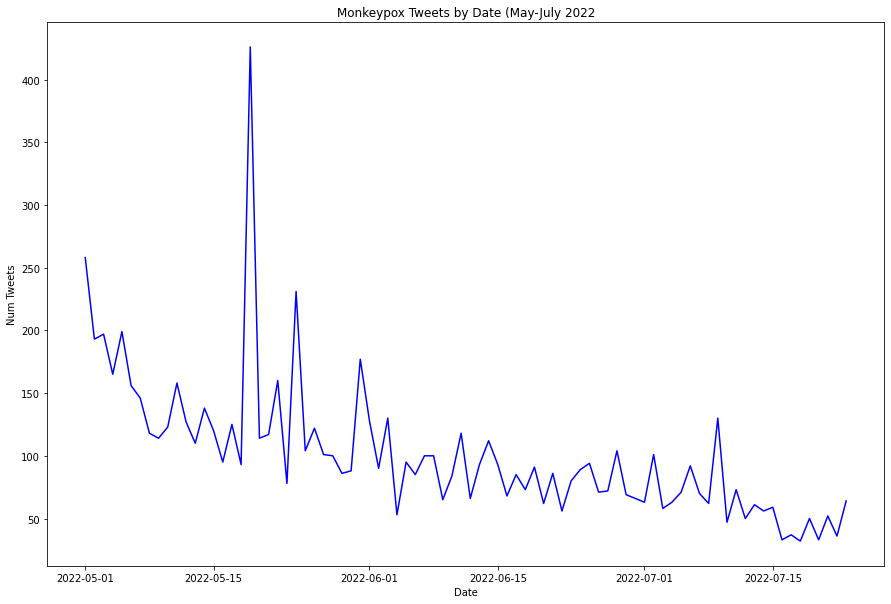

In [119]:
# Plot top stations: Rolling mean number of entres vs stations

plt.figure(figsize = (15,10))
ax = sns.lineplot(data = date_df, x = 'date', y = 'tweets_per_day', color='blue')
ax.set(title='Monkeypox Tweets by Date (May-July 2022')
ax.set(xlabel=('Date'))
ax.set(ylabel=('Num Tweets'))
plt.savefig('Tweets by Date.png');

# 6 | Deployment

Streamlit App: https://slp22-data-engineering-project-streamlit-mpx-app-ckpzq2.streamlitapp.com/

# 7 | Testing/Robustness

[Python schedule](https://schedule.readthedocs.io/en/stable/examples.html#run-a-job-every-x-minute)